In [4]:
import numpy as np
from scipy.cluster import vq
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
parent = os.path.dirname(os.path.abspath(''))

# Initial Position

In [55]:
data_path = 'AssistiveTrainable_2_dropout=0.05,input_shape=(100, 27),lr=0.005,model=lstm,num_layer=2,num_samplers=16,rdropout=0_2020-05-25_21-25-1544jzulyy'
data_path0 = os.path.join(parent,'logs','ray','discrete','lstm3',data_path,'training_data_0.npz')
data_path1 = os.path.join(parent,'logs','ray','discrete','lstm3',data_path,'training_data_1.npz')

In [56]:
obs0,target0 = np.load(data_path0).values()
obs1,target1 = np.load(data_path1).values()
obs = np.concatenate((obs0,obs1))
target = np.concatenate((target0,target1))

In [50]:
stats_path = os.path.join(parent,'data','twin','stats.npz')
stats_o,stats_t = np.load(stats_path).values()
mean_t,sd_t = stats_t

In [57]:
target = target*sd_t+mean_t

In [35]:
torso_pos = [-0.35, -0.3, 0.48549999]

In [97]:
centroid,label = vq.kmeans2(target[:,0,:],2)
if centroid[0][1] > centroid[1][1]:
    temp = centroid[0]
    centroid[0] = centroid[1]
    centroid[1] = temp
    idx0 = np.where(label == 1)[0]
    idx1 = np.where(label == 0)[0]
else:
    idx0 = np.where(label == 0)[0]
    idx1 = np.where(label == 1)[0]
print(centroid[0])
print(centroid[1])    

target_0 = target[idx0]
target_1 = target[idx1]
target_dist_0 = norm(target_0-centroid[0],axis=1)
target_dist_1 = norm(target_1-centroid[1],axis=1)
print("distance between centroids: ",norm(centroid[0]-centroid[1]))
print("cluster 0 size: ", len(idx0))
print("cluster 1 size: ", len(idx1))

[-0.32251337 -0.19862314  0.7411707 ]
[-0.28163195  0.06412622  0.81448786]
distance between centroids:  0.2758331382486991
cluster 0 size:  511
cluster 1 size:  513


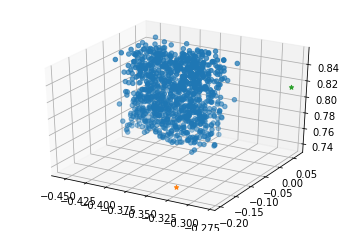

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*(obs[:,0,:3]+torso_pos)),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green')

In [100]:
dist = np.linalg.norm(obs[:,0,:3]-target[:,0,:],axis=1)
dist0 = dist[idx0]
dist1 = dist[idx1]

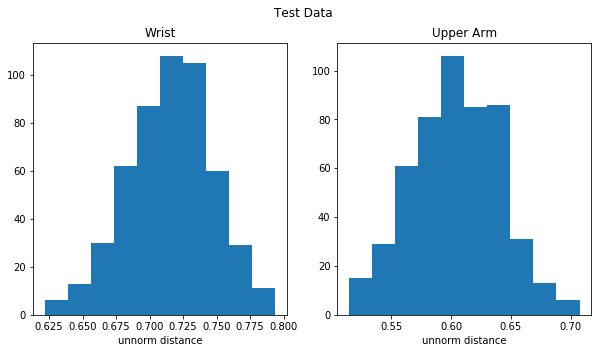

In [102]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].hist(dist0.flatten())
axs[0].set_title("Wrist")
axs[0].set_xlabel("unnorm distance")

axs[1].hist(dist1.flatten())
axs[1].set_title("Upper Arm")
axs[1].set_xlabel("unnorm distance")

plt.suptitle("Test Data")

# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])

plt.show()

# Validation Density

In [5]:
target,prediction = [],[]
for i in range(1,41):
    data = np.load(f'{parent}/test/dagger1_target_results_{1000+i}.npz')
    target.append(data['target'])
    prediction.append(data['prediction'])
target = np.concatenate(target)
prediction = np.concatenate(prediction)

In [6]:
centroid,label = vq.kmeans2(target,2)
idx0 = np.where(label == 0)[0]
idx1 = np.where(label == 1)[0]
target_0 = target[idx0]
target_1 = target[idx1]
target_dist_0 = norm(target_0-centroid[0],axis=1)
target_dist_1 = norm(target_1-centroid[1],axis=1)
print("distance between centroids: ",norm(centroid[0]-centroid[1]))
print("cluster 0 size: ", len(np.where(label==0)[0]))
print("cluster 1 size: ", len(np.where(label==1)[0]))

distance between centroids:  0.27573438801449185
cluster 0 size:  509
cluster 1 size:  491


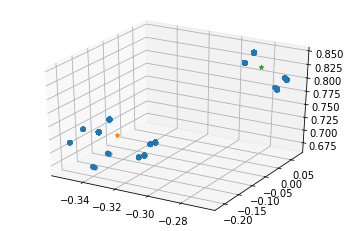

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*target),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green')

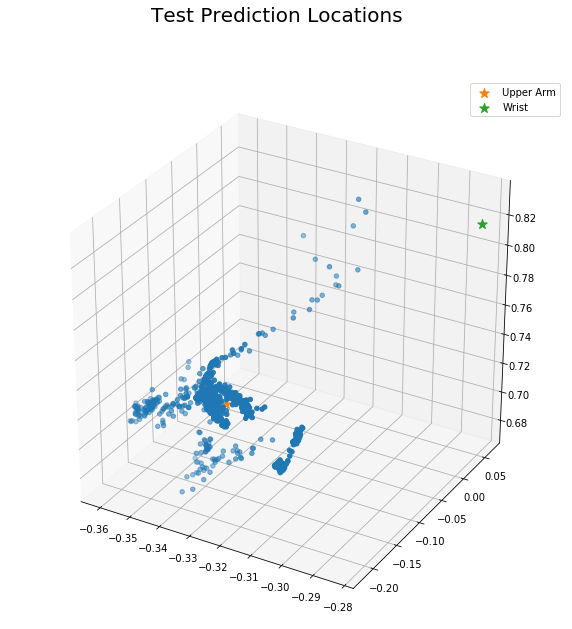

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*prediction[:,-1,:]),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange',s=100,label="Upper Arm")
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green',s=100,label="Wrist")
plt.suptitle("Test Prediction Locations",fontsize=20)
plt.legend()

In [9]:
distances = norm(prediction-target[:,np.newaxis,:],axis=2)
std = np.std(distances,axis=(0,1))
distances /= std
dist0 = distances[idx0]
dist1 = distances[idx1]

In [10]:
print(dist0.shape)

(509, 101)


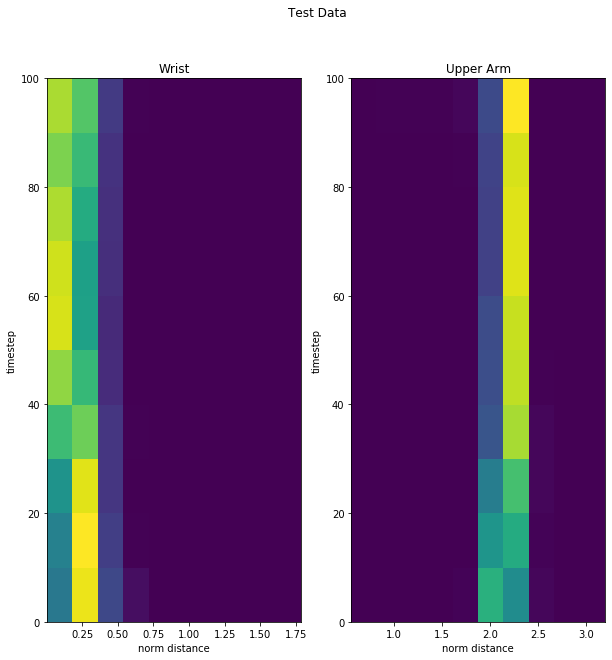

In [11]:
fig,axs = plt.subplots(1,2,figsize=(10,10))

hist0,xedges0,yedges0 = np.histogram2d(dist0.flatten(),list(range(101))*len(dist0))
extent0 = [xedges0[0], xedges0[-1], yedges0[0], yedges0[-1]]
im0 = axs[0].imshow(hist0.T, extent=extent0, origin='lower',aspect='auto')
axs[0].set_title("Wrist")
axs[0].set_xlabel("norm distance")
axs[0].set_ylabel("timestep")

hist1,xedges1,yedges1 = np.histogram2d(dist1.flatten(),list(range(101))*len(dist1))
extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
im1 = axs[1].imshow(hist1.T, extent=extent1, origin='lower',aspect='auto')
axs[1].set_title("Upper Arm")
axs[1].set_xlabel("norm distance")
axs[1].set_ylabel("timestep")

plt.suptitle("Test Data")

# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])

plt.show()

# Training Density

In [5]:
import os
parent = os.path.dirname(os.path.abspath(''))
# obs,targets = np.load(os.path.join(parent,"data","twin","noised_trajectory.npz")).values()
# del obs

In [23]:
prediction = np.load(os.path.join(parent,"data","twin","prediction.npy"))

In [24]:
centroid,label = vq.kmeans2(targets,2)
idx0 = np.where(label == 0)[0]
idx1 = np.where(label == 1)[0]
print("distance between centroids: ",norm(centroid[0]-centroid[1]))
print("cluster 0 size: ", len(np.where(label==0)[0]))
print("cluster 1 size: ", len(np.where(label==1)[0]))

distance between centroids:  0.27486924609941127
cluster 0 size:  25325
cluster 1 size:  24675


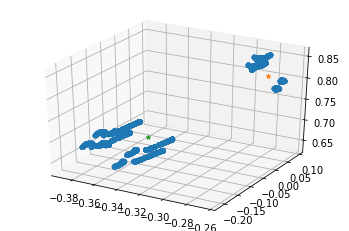

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*targets),color='tab:blue')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:orange')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:green')

In [28]:
print(std)

0.131709247085929


In [26]:
distances = norm(prediction-targets[:,np.newaxis,:],axis=2)
distances /= std
dist0 = distances[idx0]
dist1 = distances[idx1]

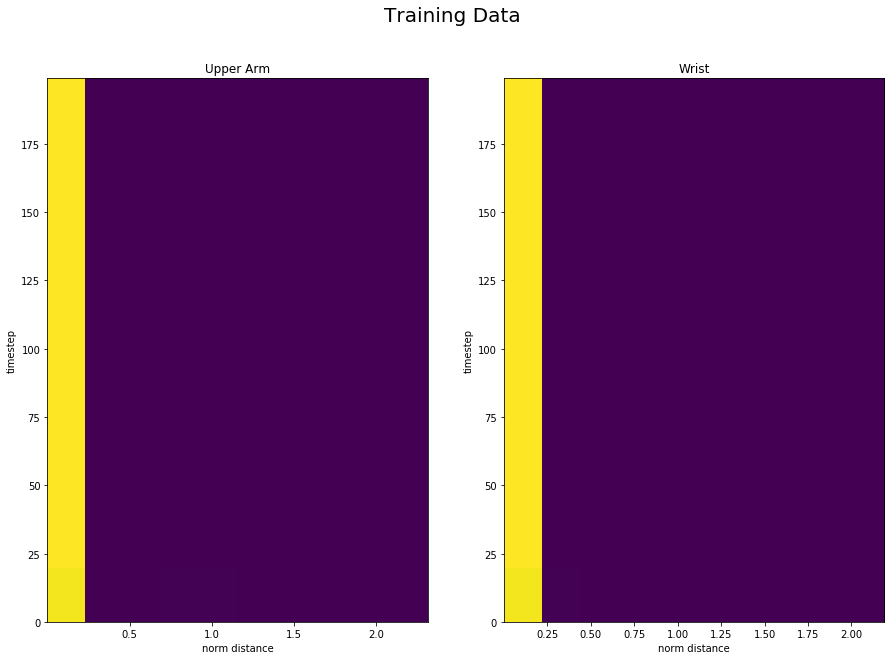

In [27]:
fig,axs = plt.subplots(1,2,figsize=(15,10))

hist0,xedges0,yedges0 = np.histogram2d(dist0.flatten(),list(range(200))*len(dist0))
extent0 = [xedges0[0], xedges0[-1], yedges0[0], yedges0[-1]]
im0 = axs[0].imshow(hist0.T, extent=extent0, origin='lower',aspect='auto')
axs[0].set_title("Upper Arm")
axs[0].set_xlabel("norm distance")
axs[0].set_ylabel("timestep")

hist1,xedges1,yedges1 = np.histogram2d(dist1.flatten(),list(range(200))*len(dist1))
extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
im1 = axs[1].imshow(hist1.T, extent=extent1, origin='lower',aspect='auto')
axs[1].set_title("Wrist")
axs[1].set_xlabel("norm distance")
axs[1].set_ylabel("timestep")

plt.suptitle("Training Data",fontsize=20)
# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])

plt.show()

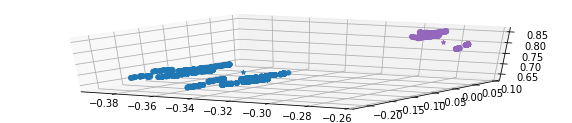

In [15]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*prediction[idx0,-1,:]),color='tab:blue')
ax.scatter(*zip(*prediction[idx1,-1,:]),color='tab:purple')
coll0 = ax.scatter(*centroid[0][:,np.newaxis],marker='*',color='tab:blue')
coll1 = ax.scatter(*centroid[1][:,np.newaxis],marker='*',color='tab:purple')

[186.67411858  30.62776683   3.20690853]
[-0.15775127 -0.12599338 -0.09423549 -0.0624776  -0.03071971  0.00103817
  0.03279606  0.06455395  0.09631184  0.12806973  0.15982762]


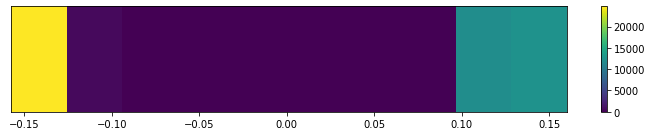

In [18]:
s,d,vt = np.linalg.svd(prediction[:,100,:],full_matrices=False)
print(d)

# plt.scatter(s.T[1]*d[1],s.T[0]*d[0])

heat,edges = np.histogram(s.T[1]*d[1])
print(edges)
extent = [edges[0],edges[-1],0,1]
plt.rcParams["figure.figsize"] = 10,2
plt.imshow(heat[np.newaxis,:],extent=extent,aspect='auto')
plt.yticks([])
# plt.tight_layout()
plt.colorbar()